In [1]:
# In[1]: Imports and Setup
import os
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl
import torch.nn.functional as F
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau

# In[2]: Configuration
early_stopping = EarlyStopping(
    monitor='val/tas/rmse', # Changed from val/pr/rmse
    min_delta=0.01,      # Adjusted min_delta, consider what's appropriate for TAS RMSE
    patience=5,
    verbose=True,
    mode='min'
)

# Checkpoint callback
# checkpoint_callback = ModelCheckpoint(
#     monitor='val/tas/rmse', # Or 'val/loss'
#     dirpath='checkpoints_tas/', # Changed from checkpoints_pr
#     filename='hybrid-cnn-transformer-tas-{epoch:02d}-{val/loss:.4f}', # Changed from pr
#     save_top_k=1,
#     mode='min',
# )

config = {
    "data": {
        "path": "processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas"], # << CHANGED TO "tas"
        "target_member_id": 0,
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245",
        "test_months": 360,
        "batch_size": 32,
        "num_workers": 0,
    },
    "model": {
        "type": "hybrid_cnn_transformer",
        "sequence_length": 12,
        "img_size_h": 48,
        "img_size_w": 72,
        "in_channels": 5,
        "out_channels": 1, # For 'tas' (single variable)
        "patch_size": 8,
        "cnn_out_channels_after_convs": 256,
        "hidden_size": 768,
        "num_heads": 12,
        "num_encoder_layers": 8,
        "mlp_ratio": 4.0,
        "dropout_rate": 0.7,
        "attention_dropout_rate": 0.03,
        "decoder_input_channels": 768,
        "decoder_init_features": 128,
        "bilinear": True,
    },
    "training": {
        "lr": 1e-4,
    },
    "trainer": {
        "max_epochs": 50,
        "accelerator": "auto",
        "devices": "auto",
        "precision": "16-mixed",
        "deterministic": True,
        "num_sanity_val_steps": 0,
        "callbacks": [],
        "log_every_n_steps": 10,
    },
    "seed": 42,
}
pl.seed_everything(config["seed"])
config["trainer"]["callbacks"].append(early_stopping)
# if checkpoint_callback is defined and you want to use it:
# config["trainer"]["callbacks"].append(checkpoint_callback)


# In[3]: Helper Functions (get_lat_weights)
def get_lat_weights(latitude_values):
    lat_rad = np.deg2rad(latitude_values)
    weights = np.cos(lat_rad)
    return weights / np.mean(weights)

# In[4]: Normalizer Class
class Normalizer:
    def __init__(self, log_transform_input=False, log_transform_output=False):
        self.mean_in, self.std_in = None, None
        self.mean_out, self.std_out = None, None
        self.log_transform_input = log_transform_input
        self.log_transform_output = log_transform_output # Will be False for 'tas'
        self.epsilon = 1e-10

    def set_input_statistics(self, mean, std):
        self.mean_in = mean
        self.std_in = std
        if isinstance(self.std_in, np.ndarray):
            self.std_in[self.std_in == 0] = self.epsilon
        elif self.std_in == 0:
            self.std_in = self.epsilon

    def set_output_statistics(self, mean, std):
        self.mean_out = mean
        self.std_out = std
        if isinstance(self.std_out, np.ndarray):
            self.std_out[self.std_out == 0] = self.epsilon
        elif self.std_out == 0:
            self.std_out = self.epsilon

    def normalize(self, data, data_type):
        if data_type == "input":
            if self.log_transform_input:
                data = np.log(data + self.epsilon)
            return (data - self.mean_in) / self.std_in
        elif data_type == "output":
            if self.log_transform_output: # False for 'tas'
                data = np.log(data + self.epsilon)
            return (data - self.mean_out) / self.std_out

    def inverse_transform_output(self, data):
        denormalized = data * self.std_out + self.mean_out
        if self.log_transform_output: # False for 'tas'
            return np.exp(denormalized) - self.epsilon
        return denormalized

    def inverse_transform_input(self, data):
        denormalized = data * self.std_in + self.mean_in
        if self.log_transform_input:
            return np.exp(denormalized) - self.epsilon
        return denormalized

# In[5]: ClimateDataset (Modified for Sequences)
class ClimateDataset(Dataset):
    def __init__(self, inputs_dask_or_np, outputs_dask_or_np, sequence_length, output_is_normalized=True, is_dask=True):
        self.sequence_length = sequence_length

        if is_dask:
            inputs_np = inputs_dask_or_np.compute()
            outputs_np = outputs_dask_or_np.compute()
        else:
            inputs_np = inputs_dask_or_np
            outputs_np = outputs_dask_or_np

        self.inputs = torch.from_numpy(inputs_np).float()
        self.outputs = torch.from_numpy(outputs_np).float()

        if torch.isnan(self.inputs).any() or torch.isnan(self.outputs).any():
            raise ValueError("NaNs found in dataset.")

        self.num_time_steps = self.inputs.shape[0]
        if self.inputs.shape[0] != self.outputs.shape[0]:
            raise ValueError(f"Inputs and outputs must have the same number of time steps. "
                             f"Got inputs: {self.inputs.shape[0]}, outputs: {self.outputs.shape[0]}")

        self.size = self.num_time_steps - self.sequence_length + 1

        if self.size <= 0:
            raise ValueError(f"Not enough data for sequence_length {self.sequence_length}. "
                             f"Need at least {self.sequence_length} time steps in the provided data, got {self.num_time_steps}.")

        print(f"Creating sequence dataset with {self.size} samples...")
        print(f"  Input tensor shape (total time steps provided to dataset): {self.inputs.shape}")
        print(f"  Output tensor shape (total time steps provided to dataset): {self.outputs.shape}")
        print(f"  Sequence length L: {self.sequence_length}")

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        input_seq = self.inputs[idx : idx + self.sequence_length]
        target = self.outputs[idx + self.sequence_length - 1]
        return input_seq, target

# In[6]: ClimateDataModule (Corrected Test Set Handling)
class ClimateDataModule(pl.LightningDataModule):
    def __init__(
        self, path, input_vars, output_vars, train_ssps, test_ssp,
        sequence_length, test_months=360, batch_size=32,
        num_workers=0, seed=42,
    ):
        super().__init__()
        self.path = path
        self.input_vars = input_vars
        self.output_vars = output_vars # Should be ["tas"]
        self.train_ssps = train_ssps
        self.test_ssp = test_ssp
        self.sequence_length = sequence_length
        self.test_months = test_months
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed
        # For 'tas', log_transform_output is False
        self.normalizer = Normalizer(log_transform_output=False) # << CHANGED log_transform_output

    def prepare_data(self):
        assert os.path.exists(self.path), f"Data path not found: {self.path}"

    def setup(self, stage=None):
        ds = xr.open_zarr(self.path, consolidated=False, chunks={"time": "auto"})
        spatial_template = ds["rsdt"].isel(time=0, ssp=0, drop=True) # Assuming 'rsdt' exists for template

        def load_ssp(ssp_scenario):
            input_dask_list, output_dask_list = [], []
            for var in self.input_vars:
                da_var = ds[var].sel(ssp=ssp_scenario)
                if "latitude" in da_var.dims: da_var = da_var.rename({"latitude": "y", "longitude": "x"})
                if "member_id" in da_var.dims: da_var = da_var.mean('member_id')
                if set(da_var.dims) == {"time"}: da_var = da_var.broadcast_like(spatial_template).transpose("time", "y", "x")
                input_dask_list.append(da_var.data)
            for var_out in self.output_vars:
                da_out_data = ds[var_out].sel(ssp=ssp_scenario)
                if "member_id" in da_out_data.dims: da_out_data = da_out_data.mean('member_id')
                if "latitude" in da_out_data.dims: da_out_data = da_out_data.rename({"latitude": "y", "longitude": "x"})
                output_dask_list.append(da_out_data.data)
            return da.stack(input_dask_list, axis=1), da.stack(output_dask_list, axis=1)

        train_input_parts, train_output_parts = [], []
        val_input_data_for_climdataset, val_output_data_for_climdataset = None, None

        for ssp in self.train_ssps:
            x, y = load_ssp(ssp)
            if ssp == "ssp370": # Using last test_months of ssp370 for validation
                val_num_timesteps_for_dataset = self.test_months + self.sequence_length -1
                if x.shape[0] < self.test_months + val_num_timesteps_for_dataset:
                    print(f"Warning: SSP {ssp} has {x.shape[0]} timesteps, not enough for val set of {self.test_months} predictions and lookback {self.sequence_length}. Adjusting val set size or source.")
                
                val_input_data_for_climdataset = x[-val_num_timesteps_for_dataset:]
                val_output_data_for_climdataset = y[-val_num_timesteps_for_dataset:]

                train_input_parts.append(x[:-self.test_months])
                train_output_parts.append(y[:-self.test_months])
            else:
                train_input_parts.append(x)
                train_output_parts.append(y)

        train_input_dask = da.concatenate(train_input_parts, axis=0)
        train_output_dask = da.concatenate(train_output_parts, axis=0)

        input_mean = da.nanmean(train_input_dask, axis=(0, 2, 3), keepdims=True).compute()
        input_std = da.nanstd(train_input_dask, axis=(0, 2, 3), keepdims=True).compute()
        output_mean = da.nanmean(train_output_dask, axis=(0, 2, 3), keepdims=True).compute()
        output_std = da.nanstd(train_output_dask, axis=(0, 2, 3), keepdims=True).compute()

        self.normalizer.set_input_statistics(mean=input_mean, std=input_std)
        self.normalizer.set_output_statistics(mean=output_mean, std=output_std)

        train_input_norm_dask = self.normalizer.normalize(train_input_dask, "input")
        train_output_norm_dask = self.normalizer.normalize(train_output_dask, "output")

        val_input_norm_dask = self.normalizer.normalize(val_input_data_for_climdataset, "input")
        val_output_norm_dask = self.normalizer.normalize(val_output_data_for_climdataset, "output")

        # --- Test Data Handling ---
        full_test_input_dask, full_test_output_dask = load_ssp(self.test_ssp)
        num_total_timesteps_for_test_dataset = self.test_months + self.sequence_length - 1

        if full_test_input_dask.shape[0] < num_total_timesteps_for_test_dataset:
            raise ValueError(f"Test SSP {self.test_ssp} has {full_test_input_dask.shape[0]} timesteps. "
                             f"Need {num_total_timesteps_for_test_dataset} for {self.test_months} predictions "
                             f"with sequence length {self.sequence_length}.")

        test_input_feed_to_dataset = full_test_input_dask[-num_total_timesteps_for_test_dataset:]
        test_output_feed_to_dataset = full_test_output_dask[-num_total_timesteps_for_test_dataset:]

        test_input_norm_dask = self.normalizer.normalize(test_input_feed_to_dataset, "input")

        self.train_dataset = ClimateDataset(train_input_norm_dask, train_output_norm_dask, self.sequence_length, is_dask=True)
        self.val_dataset = ClimateDataset(val_input_norm_dask, val_output_norm_dask, self.sequence_length, is_dask=True)

        self.test_dataset = ClimateDataset(
            test_input_norm_dask,
            test_output_feed_to_dataset, # Pass unnormalized outputs
            self.sequence_length,
            output_is_normalized=False, # Raw true values for comparison
            is_dask=True
        )
        if len(self.test_dataset) != self.test_months:
            print(f"Warning: Test dataset has {len(self.test_dataset)} samples, but expected {self.test_months} based on config.")

        self.lat = spatial_template.y.values
        self.lon = spatial_template.x.values
        self.area_weights = xr.DataArray(get_lat_weights(self.lat), dims=["y"], coords={"y": self.lat})

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, pin_memory=True)
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)
    def get_lat_weights(self): return self.area_weights
    def get_coords(self): return self.lat, self.lon

# In[7]: _UpBlock Class
class _UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_bilinear=True):
        super().__init__()
        if use_bilinear:
            self.up = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        else:
            self.up = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        self.conv_block = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        x = self.up(x)
        return self.conv_block(x)

# In[8]: CNNFeatureExtractor
class CNNFeatureExtractor(nn.Module):
    def __init__(self, in_channels, cnn_out_channels_after_convs,
                 h_orig, w_orig, target_downsample_factor, output_hidden_size):
        super().__init__()
        num_pool_layers = int(np.log2(target_downsample_factor))
        if target_downsample_factor <= 0 or (target_downsample_factor & (target_downsample_factor - 1)) != 0 and target_downsample_factor != 1:
             raise ValueError("target_downsample_factor must be a power of 2.")
        layers = []
        current_channels = in_channels
        channel_list = []
        if num_pool_layers > 0:
            base_channels = 64
            for i in range(num_pool_layers -1):
                channel_list.append(min(base_channels, cnn_out_channels_after_convs)) # Cap channels
                base_channels *= 2
            channel_list.append(cnn_out_channels_after_convs)

        for i in range(num_pool_layers):
            out_c = channel_list[i]
            layers.append(nn.Conv2d(current_channels, out_c, kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.MaxPool2d(2, 2))
            current_channels = out_c
        if num_pool_layers == 0: # Ensure output channels match if no pooling
            layers.append(nn.Conv2d(current_channels, cnn_out_channels_after_convs, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(cnn_out_channels_after_convs))
            layers.append(nn.ReLU(inplace=True))
            current_channels = cnn_out_channels_after_convs

        self.conv_layers = nn.Sequential(*layers)
        with torch.no_grad():
            dummy_input = torch.zeros(1, in_channels, h_orig, w_orig)
            cnn_output_shape = self.conv_layers(dummy_input).shape
            self.h_reduced_actual = cnn_output_shape[2]
            self.w_reduced_actual = cnn_output_shape[3]
            expected_h_reduced = h_orig // target_downsample_factor
            expected_w_reduced = w_orig // target_downsample_factor
            if self.h_reduced_actual != expected_h_reduced or self.w_reduced_actual != expected_w_reduced:
                print(f"Warning: CNNFeatureExtractor HxW output {self.h_reduced_actual}x{self.w_reduced_actual}, "
                      f"expected {expected_h_reduced}x{expected_w_reduced}.")

        self.spatial_feature_dim = current_channels * self.h_reduced_actual * self.w_reduced_actual
        self.projection = nn.Linear(self.spatial_feature_dim, output_hidden_size)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.flatten(1)
        x = self.projection(x)
        return x

# In[9]: TemporalTransformer
class TemporalTransformer(nn.Module):
    def __init__(self, hidden_size, sequence_length, num_heads, num_encoder_layers, mlp_ratio, dropout_rate):
        super().__init__()
        self.temporal_pos_embed = nn.Parameter(torch.zeros(1, sequence_length, hidden_size))
        self.pos_drop = nn.Dropout(p=dropout_rate)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size, nhead=num_heads,
            dim_feedforward=int(hidden_size * mlp_ratio),
            dropout=dropout_rate, activation=F.gelu,
            batch_first=True, norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.encoder_norm = nn.LayerNorm(hidden_size)
    def forward(self, x):
        x = x + self.temporal_pos_embed
        x = self.pos_drop(x)
        x = self.transformer_encoder(x)
        x = self.encoder_norm(x)
        return x

# In[10]: Decoder
class Decoder(nn.Module):
    def __init__(self, transformer_hidden_size, decoder_input_channels,
                 h_reduced, w_reduced,
                 num_upsamples, decoder_init_features, bilinear, out_channels):
        super().__init__()
        self.h_reduced = h_reduced
        self.w_reduced = w_reduced
        self.decoder_input_channels = decoder_input_channels
        self.projection = nn.Linear(transformer_hidden_size, decoder_input_channels * h_reduced * w_reduced)
        decoder_layers = []
        current_channels = decoder_input_channels
        for i in range(num_upsamples):
            out_block_channels = decoder_init_features * (2**(num_upsamples - 1 - i))
            decoder_layers.append(_UpBlock(current_channels, out_block_channels, use_bilinear=bilinear))
            current_channels = out_block_channels
        self.decoder_blocks = nn.Sequential(*decoder_layers)
        self.decoder_final_conv = nn.Conv2d(current_channels, out_channels, kernel_size=1)
    def forward(self, x_transformer_last_step):
        x = self.projection(x_transformer_last_step)
        x = x.view(-1, self.decoder_input_channels, self.h_reduced, self.w_reduced)
        x = self.decoder_blocks(x)
        x = self.decoder_final_conv(x)
        return x

# In[11]: HybridCNNTransformer Model
class HybridCNNTransformer(nn.Module):
    def __init__(self, model_config):
        super().__init__()
        self.sequence_length = model_config["sequence_length"]
        self.img_size_h = model_config["img_size_h"]
        self.img_size_w = model_config["img_size_w"]
        self.hidden_size = model_config["hidden_size"]
        self.cnn_downsample_factor = model_config["patch_size"] # This is used as the downsample factor

        self.cnn_extractor = CNNFeatureExtractor(
            in_channels=model_config["in_channels"],
            cnn_out_channels_after_convs=model_config["cnn_out_channels_after_convs"],
            h_orig=self.img_size_h, w_orig=self.img_size_w,
            target_downsample_factor=self.cnn_downsample_factor,
            output_hidden_size=self.hidden_size
        )
        self.temporal_transformer = TemporalTransformer(
            hidden_size=self.hidden_size, sequence_length=self.sequence_length,
            num_heads=model_config["num_heads"], num_encoder_layers=model_config["num_encoder_layers"],
            mlp_ratio=model_config["mlp_ratio"], dropout_rate=model_config["dropout_rate"]
        )
        num_upsamples = int(np.log2(self.cnn_downsample_factor))
        if self.cnn_downsample_factor <= 0 or \
           (self.cnn_downsample_factor & (self.cnn_downsample_factor - 1)) != 0 and self.cnn_downsample_factor != 1:
             raise ValueError("cnn_downsample_factor (from patch_size) must be a power of 2 for decoder logic.")

        actual_h_reduced_from_cnn = self.cnn_extractor.h_reduced_actual
        actual_w_reduced_from_cnn = self.cnn_extractor.w_reduced_actual

        self.decoder = Decoder(
            transformer_hidden_size=self.hidden_size,
            decoder_input_channels=model_config["decoder_input_channels"],
            h_reduced=actual_h_reduced_from_cnn,
            w_reduced=actual_w_reduced_from_cnn,
            num_upsamples=num_upsamples, decoder_init_features=model_config["decoder_init_features"],
            bilinear=model_config["bilinear"], out_channels=model_config["out_channels"],
        )
    def forward(self, x_seq):
        batch_size = x_seq.size(0)
        cnn_input = x_seq.view(batch_size * self.sequence_length,
                               x_seq.size(2), x_seq.size(3), x_seq.size(4))
        spatial_features = self.cnn_extractor(cnn_input)
        transformer_input = spatial_features.view(batch_size, self.sequence_length, self.hidden_size)
        temporal_features = self.temporal_transformer(transformer_input)
        last_step_features = temporal_features[:, -1, :]
        predicted_map = self.decoder(last_step_features)
        return predicted_map

# In[12]: ClimateEmulationModule
class ClimateEmulationModule(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4, config_data=None):
        super().__init__()
        self.model = model
        self.save_hyperparameters(ignore=['model', 'config_data'])
        self.criterion = nn.MSELoss()
        self.normalizer = None
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []
        self.train_losses = []
        self.val_losses = []
        self.config_data = config_data # Store config_data

    def forward(self, x): return self.model(x)

    def on_fit_start(self):
        if hasattr(self.trainer.datamodule, 'normalizer'):
             self.normalizer = self.trainer.datamodule.normalizer
        else:
             raise AttributeError("DataModule does not have a 'normalizer' attribute.")

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.val_losses.append(loss.item())
        if self.normalizer:
            y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
            y_np = self.normalizer.inverse_transform_output(y.detach().cpu().numpy())
            self.val_preds.append(y_hat_np)
            self.val_targets.append(y_np)
        return loss

    def on_validation_epoch_end(self):
        if not self.val_preds:
            self.val_preds.clear(); self.val_targets.clear()
            return
        preds = np.concatenate(self.val_preds, axis=0)
        trues = np.concatenate(self.val_targets, axis=0)
        self._evaluate(preds, trues, phase="val")
        self.val_preds.clear(); self.val_targets.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        if self.normalizer:
            y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        else:
            y_hat_np = y_hat.detach().cpu().numpy()
        y_np = y.detach().cpu().numpy() # Test targets are raw
        self.test_preds.append(y_hat_np)
        self.test_targets.append(y_np)

    def on_test_epoch_end(self):
        if not self.test_preds: return
        preds = np.concatenate(self.test_preds, axis=0)
        trues = np.concatenate(self.test_targets, axis=0)
        self._evaluate(preds, trues, phase="test")
        # Use self.config_data if available, otherwise fallback to datamodule.output_vars
        output_vars_for_submission = self.config_data["output_vars"] if self.config_data else self.trainer.datamodule.output_vars
        self._save_submission(preds, output_vars=output_vars_for_submission)
        self.test_preds.clear(); self.test_targets.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)
        # The monitor key will dynamically use the first output variable (e.g., 'tas')
        scheduler = {
            'scheduler': ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-7),
            'monitor': f'val/{self.trainer.datamodule.output_vars[0]}/rmse', # e.g., val/tas/rmse
            'interval': 'epoch', 'frequency': 1,
        }
        return [optimizer], [scheduler]

    def _evaluate(self, preds, trues, phase="val"):
        datamodule = self.trainer.datamodule
        area_weights = datamodule.get_lat_weights()
        lat, lon = datamodule.get_coords()
        time = np.arange(preds.shape[0])
        output_vars = datamodule.output_vars # Should be ["tas"]

        for i, var in enumerate(output_vars): # var will be "tas"
            p = preds[:, i]; t = trues[:, i]
            p_xr = xr.DataArray(p, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
            t_xr = xr.DataArray(t, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean(("time", "y", "x")).item())
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2).weighted(area_weights).mean(("y", "x")).item())
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean(("y", "x")).item()
            print(f"[{phase.upper()}] {var}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            self.log_dict({
                f"{phase}/{var}/rmse": rmse, f"{phase}/{var}/time_mean_rmse": mean_rmse,
                f"{phase}/{var}/time_std_mae": std_mae,
            }) # Logged metrics will be like "val/tas/rmse"

    def _save_submission(self, predictions, output_vars): # output_vars will be ["tas"]
        datamodule = self.trainer.datamodule
        lat, lon = datamodule.get_coords()
        time = np.arange(predictions.shape[0])
        print(f"Generating submission CSV with {predictions.shape[0]} time steps.")

        rows = []
        for t_idx, t_val in enumerate(time):
            for var_idx, var in enumerate(output_vars): # var will be "tas"
                for y_idx, y_val in enumerate(lat):
                    for x_idx, x_val in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var}_{y_val:.2f}_{x_val:.2f}" # row_id will include "tas"
                        pred = predictions[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred})
        df = pd.DataFrame(rows)
        os.makedirs("submissions", exist_ok=True)
        submission_var_name = output_vars[0] if output_vars else "predictions" # Will be "tas"
        filepath = f"submissions/kaggle_submission_hybrid_{submission_var_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filepath, index=False)
        print(f"✅ Submission saved to: {filepath} with {len(df)} rows.")


# In[13]: Instantiate DataModule
cdm = ClimateDataModule(
    path=config["data"]["path"], input_vars=config["data"]["input_vars"],
    output_vars=config["data"]["output_vars"], # Now ["tas"] from config
    train_ssps=config["data"]["train_ssps"], test_ssp=config["data"]["test_ssp"],
    sequence_length=config["model"]["sequence_length"],
    test_months=config["data"]["test_months"], batch_size=config["data"]["batch_size"],
    num_workers=config["data"]["num_workers"], seed=config["seed"],
)
cdm.prepare_data()
cdm.setup()
print(f"Train dataset size (number of sequences): {len(cdm.train_dataset)}")
print(f"Validation dataset size (number of sequences): {len(cdm.val_dataset)}")
print(f"Test dataset size (number of sequences): {len(cdm.test_dataset)}")


# In[14]: Instantiate Model and LightningModule
hybrid_model = HybridCNNTransformer(model_config=config["model"])
climate_emulation_module = ClimateEmulationModule(
    model=hybrid_model, learning_rate=config["training"]["lr"], config_data=config["data"] # Pass config_data here
)

# In[15]: Trainer and Training
trainer = pl.Trainer(
    max_epochs=config["trainer"]["max_epochs"], accelerator=config["trainer"]["accelerator"],
    devices=config["trainer"]["devices"], precision=config["trainer"]["precision"],
    deterministic=config["trainer"]["deterministic"], num_sanity_val_steps=config["trainer"]["num_sanity_val_steps"],
    callbacks=config["trainer"]["callbacks"], log_every_n_steps=config["trainer"]["log_every_n_steps"],
)
print("Starting training...")
trainer.fit(climate_emulation_module, cdm)
print("Training finished.")

Seed set to 42


Creating sequence dataset with 2692 samples...
  Input tensor shape (total time steps provided to dataset): torch.Size([2703, 5, 48, 72])
  Output tensor shape (total time steps provided to dataset): torch.Size([2703, 1, 48, 72])
  Sequence length L: 12
Creating sequence dataset with 360 samples...
  Input tensor shape (total time steps provided to dataset): torch.Size([371, 5, 48, 72])
  Output tensor shape (total time steps provided to dataset): torch.Size([371, 1, 48, 72])
  Sequence length L: 12
Creating sequence dataset with 360 samples...
  Input tensor shape (total time steps provided to dataset): torch.Size([371, 5, 48, 72])
  Output tensor shape (total time steps provided to dataset): torch.Size([371, 1, 48, 72])
  Sequence length L: 12
Train dataset size (number of sequences): 2692
Validation dataset size (number of sequences): 360
Test dataset size (number of sequences): 360


/home/dpachchigar/.local/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Starting training...


2025-05-25 18:42:34.002461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748198554.026961    2072 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748198554.034513    2072 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-25 18:42:34.060811: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Creating sequence dataset with 2692 samples...
  Input tensor shape (total time steps provided to dataset): torch.Size([2703, 5, 48, 72])
  Output tensor shape (total time steps provided to dataset): torch.Size([2703, 1, 48, 72])
  Sequence length L: 12
Creating sequence dataset with 360 samples...
  Input tensor shape (total time steps provided to dataset): torch.Size([371, 5, 48, 72])
  Output tensor shape (total time steps provided to dataset): torch.Size([371, 1, 48, 72])
  Sequence length L: 12


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Creating sequence dataset with 360 samples...
  Input tensor shape (total time steps provided to dataset): torch.Size([371, 5, 48, 72])
  Output tensor shape (total time steps provided to dataset): torch.Size([371, 1, 48, 72])
  Sequence length L: 12



  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | HybridCNNTransformer | 111 M  | train
1 | criterion | MSELoss              | 0      | train
-----------------------------------------------------------
111 M     Trainable params
0         Non-trainable params
111 M     Total params
446.335   Total estimated model params size (MB)
154       Modules in train mode
0         Modules in eval mode
/home/dpachchigar/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/home/dpachchigar/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved. New best score: 5.141


[VAL] tas: RMSE=5.1406, Time-Mean RMSE=3.9473, Time-Stddev MAE=1.5423


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.953 >= min_delta = 0.01. New best score: 4.188


[VAL] tas: RMSE=4.1876, Time-Mean RMSE=2.8773, Time-Stddev MAE=1.4458


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.677 >= min_delta = 0.01. New best score: 3.511


[VAL] tas: RMSE=3.5111, Time-Mean RMSE=2.4194, Time-Stddev MAE=1.1547


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.359 >= min_delta = 0.01. New best score: 3.152


[VAL] tas: RMSE=3.1518, Time-Mean RMSE=2.2543, Time-Stddev MAE=0.9553


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.724 >= min_delta = 0.01. New best score: 2.427


[VAL] tas: RMSE=2.4273, Time-Mean RMSE=1.8184, Time-Stddev MAE=0.4949


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.279 >= min_delta = 0.01. New best score: 2.149


[VAL] tas: RMSE=2.1488, Time-Mean RMSE=1.6994, Time-Stddev MAE=0.4901


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.288 >= min_delta = 0.01. New best score: 1.860


[VAL] tas: RMSE=1.8605, Time-Mean RMSE=1.3869, Time-Stddev MAE=0.4005


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.314 >= min_delta = 0.01. New best score: 1.547


[VAL] tas: RMSE=1.5466, Time-Mean RMSE=1.0663, Time-Stddev MAE=0.4163


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5972, Time-Mean RMSE=1.0937, Time-Stddev MAE=0.3757


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.049 >= min_delta = 0.01. New best score: 1.498


[VAL] tas: RMSE=1.4976, Time-Mean RMSE=0.9998, Time-Stddev MAE=0.3332



Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

Starting testing...
Creating sequence dataset with 2692 samples...
  Input tensor shape (total time steps provided to dataset): torch.Size([2703, 5, 48, 72])
  Output tensor shape (total time steps provided to dataset): torch.Size([2703, 1, 48, 72])
  Sequence length L: 12
Creating sequence dataset with 360 samples...
  Input tensor shape (total time steps provided to dataset): torch.Size([371, 5, 48, 72])
  Output tensor shape (total time steps provided to dataset): torch.Size([371, 1, 48, 72])
  Sequence length L: 12


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Creating sequence dataset with 360 samples...
  Input tensor shape (total time steps provided to dataset): torch.Size([371, 5, 48, 72])
  Output tensor shape (total time steps provided to dataset): torch.Size([371, 1, 48, 72])
  Sequence length L: 12


/home/dpachchigar/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

[TEST] tas: RMSE=291.6289, Time-Mean RMSE=291.5893, Time-Stddev MAE=3.5301
Generating submission CSV with 360 time steps.
✅ Submission saved to: submissions/kaggle_submission_hybrid_tas_20250525_184751.csv with 1244160 rows.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/tas/rmse       │       291.62890625        │
│  test/tas/time_mean_rmse  │     291.5893249511719     │
│   test/tas/time_std_mae   │    3.5301191806793213     │
└───────────────────────────┴───────────────────────────┘

Testing finished.


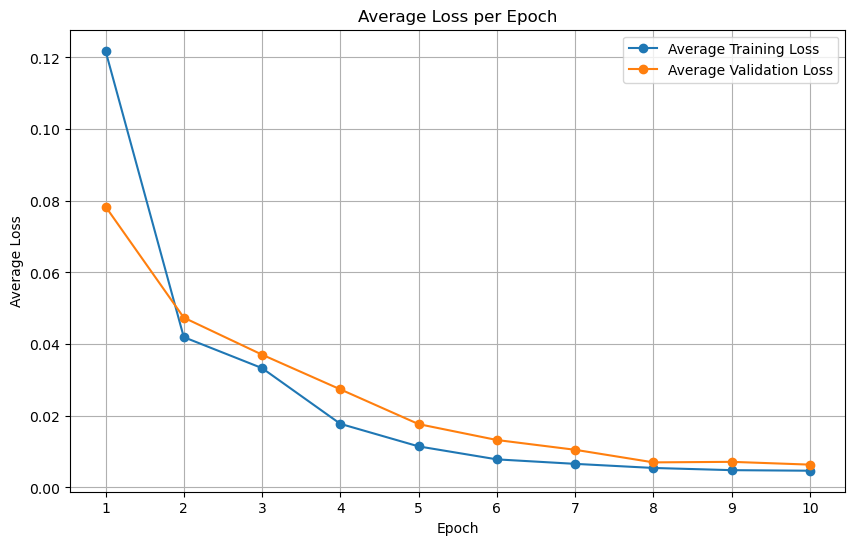

In [2]:
print("Starting testing...")
trainer.test(climate_emulation_module, datamodule=cdm)
print("Testing finished.")

# In[17]: Plotting Training/Validation Losses
training_batch_losses = climate_emulation_module.train_losses
validation_batch_losses = climate_emulation_module.val_losses
num_train_batches_per_epoch = len(cdm.train_dataloader()) if len(cdm.train_dataloader()) > 0 else 1
num_val_batches_per_epoch = len(cdm.val_dataloader()) if len(cdm.val_dataloader()) > 0 else 1

avg_train_loss_per_epoch = []
if num_train_batches_per_epoch > 0 and len(training_batch_losses) >= num_train_batches_per_epoch :
    num_train_epochs_completed = len(training_batch_losses) // num_train_batches_per_epoch
    for i in range(num_train_epochs_completed):
        epoch_train_losses = training_batch_losses[i*num_train_batches_per_epoch:(i+1)*num_train_batches_per_epoch]
        if epoch_train_losses: avg_train_loss_per_epoch.append(np.mean(epoch_train_losses))
avg_val_loss_per_epoch = []
if num_val_batches_per_epoch > 0 and len(validation_batch_losses) >= num_val_batches_per_epoch:
    num_val_epochs_completed = len(validation_batch_losses) // num_val_batches_per_epoch
    for i in range(num_val_epochs_completed):
        epoch_val_losses = validation_batch_losses[i*num_val_batches_per_epoch:(i+1)*num_val_batches_per_epoch]
        if epoch_val_losses: avg_val_loss_per_epoch.append(np.mean(epoch_val_losses))

epochs_train = np.arange(1, len(avg_train_loss_per_epoch) + 1)
epochs_val = np.arange(1, len(avg_val_loss_per_epoch) + 1)
plt.figure(figsize=(10, 6))
if avg_train_loss_per_epoch: plt.plot(epochs_train, avg_train_loss_per_epoch, 'o-', label='Average Training Loss')
else: print("No average training loss data to plot.")
if avg_val_loss_per_epoch: plt.plot(epochs_val, avg_val_loss_per_epoch, 'o-', label='Average Validation Loss')
else: print("No average validation loss data to plot.")
plt.title('Average Loss per Epoch'); plt.xlabel('Epoch'); plt.ylabel('Average Loss')
plt.legend(); plt.grid(True)
if len(epochs_train) > 0 or len(epochs_val) > 0:
    max_epoch_plot = max(len(epochs_train), len(epochs_val))
    if max_epoch_plot > 0 : plt.xticks(np.arange(1, max_epoch_plot + 1, step=max(1, max_epoch_plot // 10)))
plt.show()

In [19]:
def plot_comparison(true_xr, pred_xr, title, cmap='viridis', diff_cmap='RdBu_r', metric=None):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    vmin = min(true_xr.min().item(), pred_xr.min().item())
    vmax = max(true_xr.max().item(), pred_xr.max().item())

    # Ground truth
    true_xr.plot(ax=axs[0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[0].set_title(f"{title} (Ground Truth)")

    # Prediction
    pred_xr.plot(ax=axs[1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[1].set_title(f"{title} (Prediction)")

    # Difference
    diff = pred_xr - true_xr
    abs_max = np.max(np.abs(diff))
    diff.plot(ax=axs[2], cmap=diff_cmap, vmin=-abs_max, vmax=abs_max, add_colorbar=True)
    axs[2].set_title(f"{title} (Difference) {f'- {metric:.4f}' if metric else ''}")

    plt.tight_layout()
    plt.show()


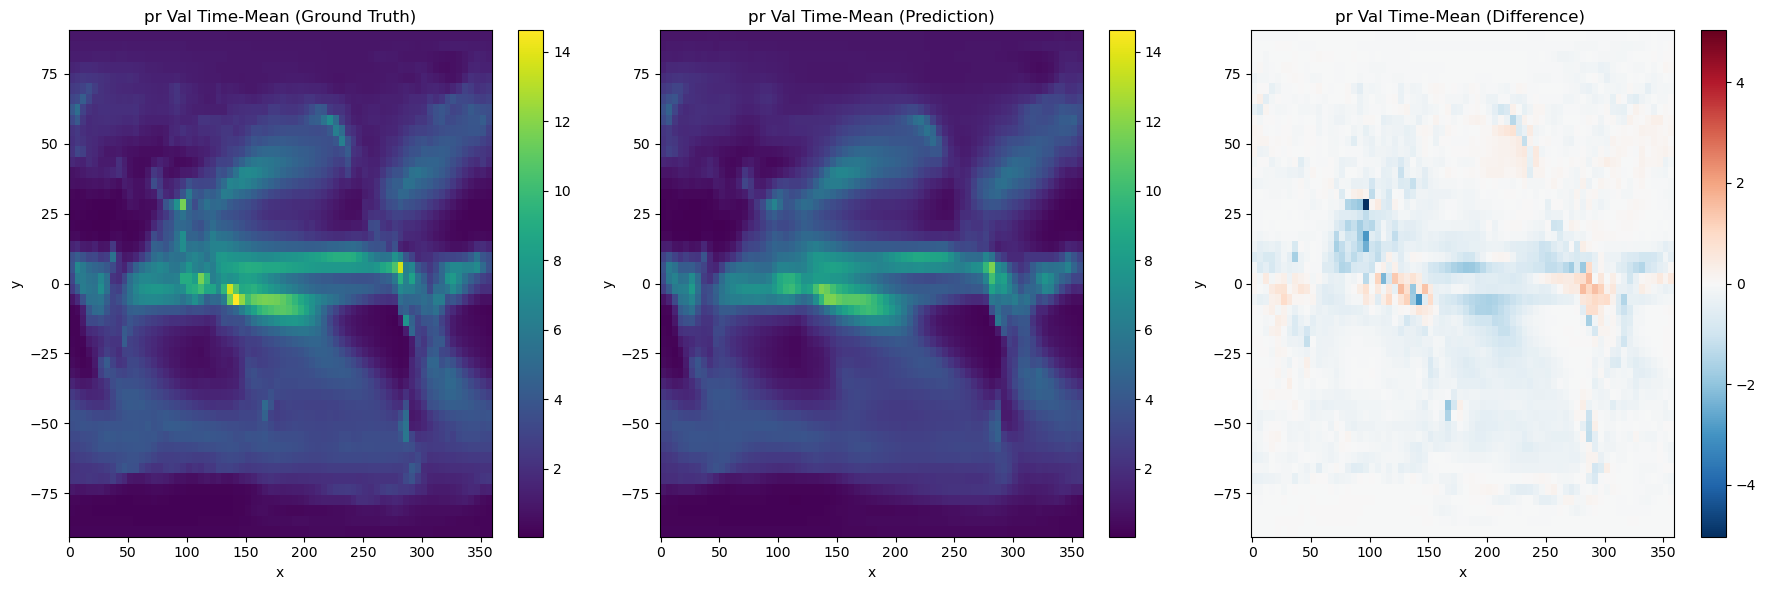

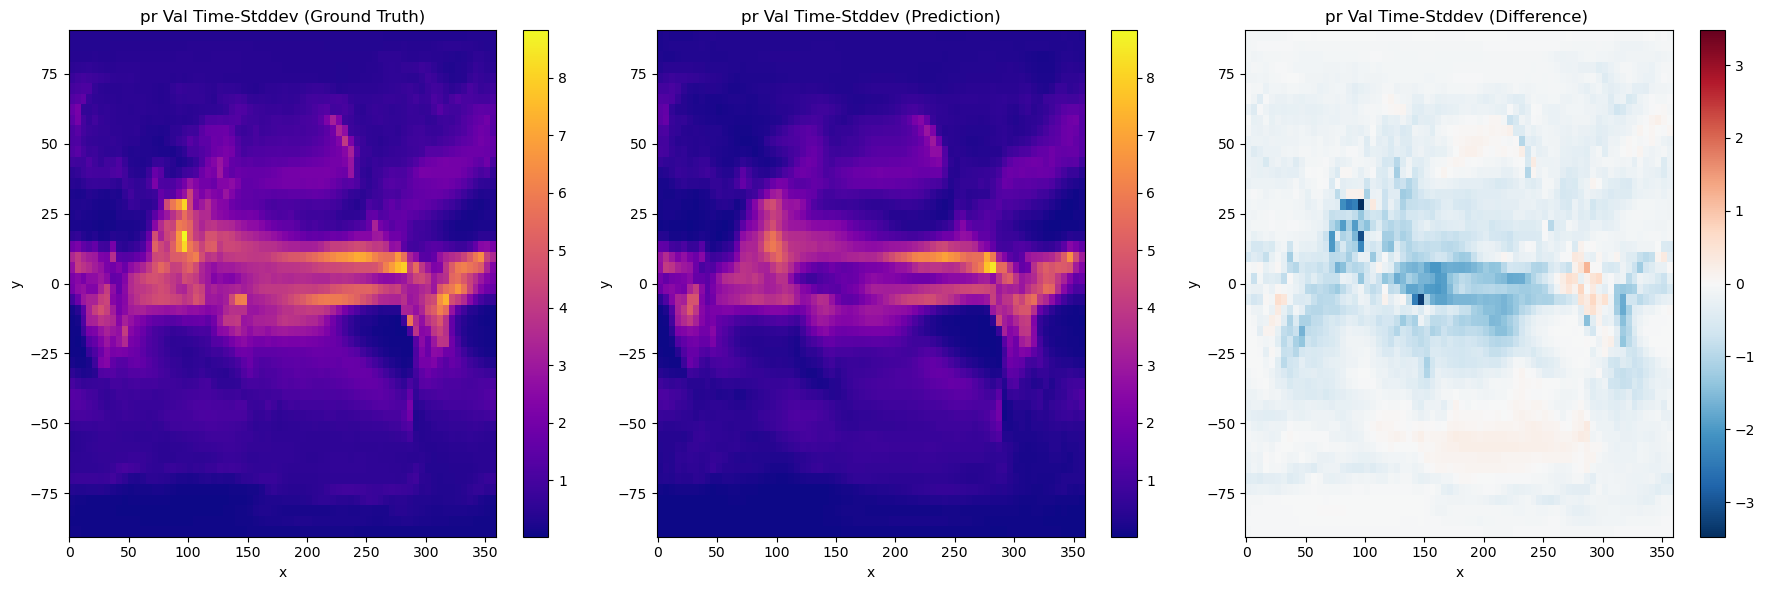

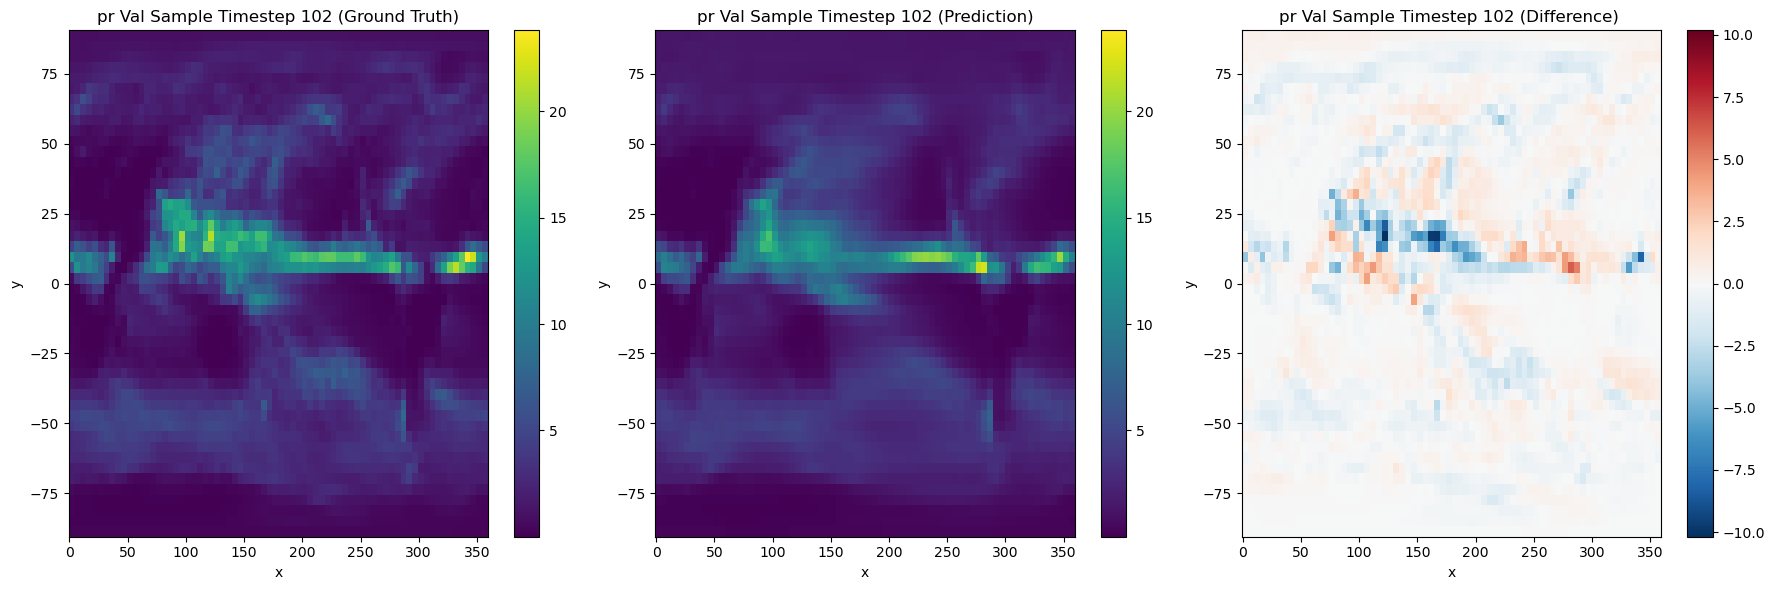

In [20]:
# Load validation predictions
# make sure to have run the validation loop at least once
val_preds = np.load("val_preds.npy")
val_trues = np.load("val_trues.npy")

lat, lon = cdm.get_coords()
output_vars = cdm.output_vars
time = np.arange(val_preds.shape[0])

for i, var in enumerate(output_vars):
    pred_xr = xr.DataArray(val_preds[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
    true_xr = xr.DataArray(val_trues[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

    # --- Time Mean ---
    plot_comparison(true_xr.mean("time"), pred_xr.mean("time"), f"{var} Val Time-Mean")

    # --- Time Stddev ---
    plot_comparison(true_xr.std("time"), pred_xr.std("time"), f"{var} Val Time-Stddev", cmap="plasma")

    # --- Random timestep ---
    t_idx = np.random.randint(0, len(time))
    plot_comparison(true_xr.isel(time=t_idx), pred_xr.isel(time=t_idx), f"{var} Val Sample Timestep {t_idx}")


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'climate_model' is your trained ClimateEmulationModule instance
# and 'cdm' is your ClimateDataModule instance.

# These lists contain per-batch losses accumulated during training
training_batch_losses = climate_model.train_losses
validation_batch_losses = climate_model.val_losses

# Get the number of batches per epoch from your dataloaders
# This is important for correctly averaging per epoch
num_train_batches_per_epoch = len(cdm.train_dataloader())
num_val_batches_per_epoch = len(cdm.val_dataloader())

# Calculate average training loss per epoch
avg_train_loss_per_epoch = []
if num_train_batches_per_epoch > 0:
    num_train_epochs_completed = len(training_batch_losses) // num_train_batches_per_epoch
    for i in range(num_train_epochs_completed):
        start_idx = i * num_train_batches_per_epoch
        end_idx = start_idx + num_train_batches_per_epoch
        epoch_train_losses = training_batch_losses[start_idx:end_idx]
        if epoch_train_losses: # Make sure there are losses to average
            avg_train_loss_per_epoch.append(np.mean(epoch_train_losses))

# Calculate average validation loss per epoch
avg_val_loss_per_epoch = []
if num_val_batches_per_epoch > 0:
    num_val_epochs_completed = len(validation_batch_losses) // num_val_batches_per_epoch
    for i in range(num_val_epochs_completed):
        start_idx = i * num_val_batches_per_epoch
        end_idx = start_idx + num_val_batches_per_epoch
        epoch_val_losses = validation_batch_losses[start_idx:end_idx]
        if epoch_val_losses: # Make sure there are losses to average
            avg_val_loss_per_epoch.append(np.mean(epoch_val_losses))

# Create epoch arrays for plotting
epochs_train = np.arange(1, len(avg_train_loss_per_epoch) + 1)
epochs_val = np.arange(1, len(avg_val_loss_per_epoch) + 1)

# Plotting
plt.figure(figsize=(10, 6))
if avg_train_loss_per_epoch:
    plt.plot(epochs_train, avg_train_loss_per_epoch, 'o-', label='Average Training Loss per Epoch')
else:
    print("No average training loss data to plot.")

if avg_val_loss_per_epoch:
    plt.plot(epochs_val, avg_val_loss_per_epoch, 'o-', label='Average Validation Loss per Epoch')
else:
    print("No average validation loss data to plot. This might happen if validation_batch_losses was empty or num_val_batches_per_epoch was zero.")


plt.title('Average Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
# Ensure integer ticks for epochs if data is available
if len(epochs_train) > 0 or len(epochs_val) > 0:
    max_epoch = max(len(epochs_train), len(epochs_val))
    if max_epoch > 0 :
        plt.xticks(np.arange(1, max_epoch + 1, step=max(1, max_epoch // 10))) # Adjust step for readability

plt.show()

# As a sanity check, print the number of epochs for which data was found
print(f"Number of epochs for average training loss: {len(avg_train_loss_per_epoch)}")
print(f"Number of epochs for average validation loss: {len(avg_val_loss_per_epoch)}")
print(f"Total training batches recorded: {len(training_batch_losses)}")
print(f"Total validation batches recorded: {len(validation_batch_losses)}")
if hasattr(trainer, 'current_epoch'):
    print(f"Trainer current epoch (0-indexed for last completed, so +1 for count): {trainer.current_epoch +1 }")

NameError: name 'climate_model' is not defined